## Confirm access to a GPU

In [1]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce GTX 1650 Ti (UUID: GPU-41875beb-7fdb-c4c1-23a2-812ef53ab0f7)


# Project : PAPER PILOT

The purpose of this notebook is to build an NLP model to make reading medical abstracts easier.

Reference Paper : [https://arxiv.org/pdf/1710.06071.pdf](https://arxiv.org/pdf/1710.06071.pdf)

model architechtures : [https://arxiv.org/pdf/1612.05251.pdf](https://arxiv.org/pdf/1612.05251.pdf)

## Get data

download the PubMed 200k RCT dataset. txt files [on GitHub](https://github.com/Franck-Dernoncourt/pubmed-rct).
We can copy them to our local directory using `git clone https://github.com/Franck-Dernoncourt/pubmed-rct`

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!dir pubmed-rct

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.


 Volume in drive D is New Volume
 Volume Serial Number is AEB7-FE5C

 Directory of d:\my books\my books\semester2\Projects\NLP\pubmed-rct

24-03-2024  06:49    <DIR>          .
25-03-2024  10:53    <DIR>          ..
24-03-2024  06:49    <DIR>          PubMed_200k_RCT
24-03-2024  06:49    <DIR>          PubMed_200k_RCT_numbers_replaced_with_at_sign
24-03-2024  06:49    <DIR>          PubMed_20k_RCT
24-03-2024  06:49    <DIR>          PubMed_20k_RCT_numbers_replaced_with_at_sign
24-03-2024  06:49             3,733 README.md
               1 File(s)          3,733 bytes
               6 Dir(s)  122,591,080,448 bytes free


In [3]:
# Checking what files are in the PubMed_20K daatset
!dir pubmed-rct\PubMed_20k_RCT_numbers_replaced_with_at_sign


 Volume in drive D is New Volume
 Volume Serial Number is AEB7-FE5C

 Directory of d:\my books\my books\semester2\Projects\NLP\pubmed-rct\PubMed_20k_RCT_numbers_replaced_with_at_sign

24-03-2024  06:49    <DIR>          .
24-03-2024  06:49    <DIR>          ..
24-03-2024  06:49         4,880,409 dev.txt
24-03-2024  06:49         4,846,504 test.txt
24-03-2024  06:49        29,118,832 train.txt
               3 File(s)     38,845,745 bytes
               2 Dir(s)  122,591,080,448 bytes free


In [4]:
# start by 20k dataset replacing numbers with @
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [5]:
# Check all of the filenames in the PubMed_20K dataset
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

## Preprocess data

Create a function to read in all of the lines of a target text file.

In [6]:
# Create a function that can read the lines of  a document
def get_lines(filename):
  """
  Reads filename (a text file) and returns the lines of text as a list.
  Args:
    filename: a string containing the target filepath.
  Return: 
    a list of strings with one string per line from the target filename.
  """
  with open(filename, "r") as f:
    return f.readlines()

In [7]:
# read in from the training lines in dataset
train_lines = get_lines(data_dir + "train.txt")
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [8]:
len(train_lines)

210040

Example returned preprocessed sample (a single line from an abstract):

```
[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
  ...]
  
```

In [9]:
def preprocess_text_with_line_numbers(filename):
    """
    Returns a list of dictionaries of abstract line data.
    Takes in filename, reads its contents and sorts through each line,
    extracting things like the target label, the text of the sentence,
    how many sentences are in the current abstract and what sentence number
    the target line is.
    Args:
        filename: a string containing the target filepath.
    Returns:
        A list of dictionaries each containing features of a sentence in the abstract.
    """
    input_lines = get_lines(filename) # get all lines from filename
    abstract_lines = "" # create an empty abstract
    abstract_samples = [] # create an empty list to hold abstracts

    # Loop through each line in the target file
    for lines in input_lines:
        if lines.startswith("###"): # check to see if the line is an ID line
            abstract_id = lines
            abstract_lines = "" # reset the abstract string if the line is an ID line
        elif lines.isspace(): # check to see if the line is a new line
            abstract_line_split = abstract_lines.splitlines() # split the abstract into separate lines

            # Iterate through each line in a single abstract and count them at the same time
            for abstract_line_number, abstract_line in enumerate(abstract_line_split):
                line_data = {} # create an empty dictionary for each line
                target_text_split = abstract_line.split("\t") # split the target label from the text of the sentence
                line_data["target"] = target_text_split[0] # get the target label
                line_data["text"] = target_text_split[1].lower() # get the text of the sentence
                line_data["line_number"] = abstract_line_number # what number line does the sentence appear in the abstract
                line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract, subtract 1 to get 0 indexing
                abstract_samples.append(line_data) # add the line data to our list of abstracts
        
        else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
            abstract_lines += lines

    return abstract_samples
    

In [10]:
# Get data from file and preprocess it
%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") # dev is another name for validation set
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
len(train_samples), len(val_samples), len(test_samples)

CPU times: total: 0 ns
Wall time: 0 ns


(180040, 30212, 30135)

In [11]:
# Check the first abstract of our training data
train_samples[:12]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

turn list of dictionaries into pandas DataFrame

In [12]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [13]:
# Distribution of labels in training data
train_df["target"].value_counts()

target
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

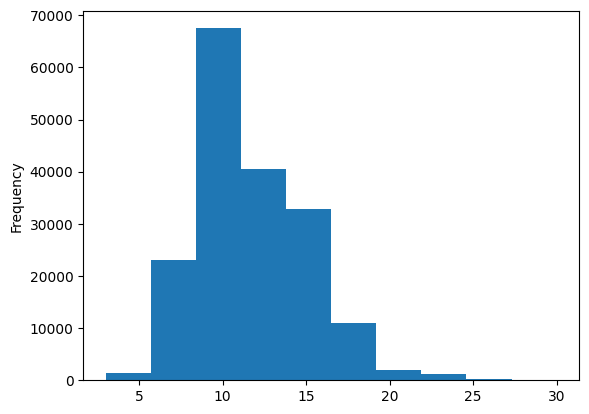

In [14]:
# Let's check the length of different lines
train_df.total_lines.plot.hist()

### Get lists of sentences

When we build our deep learning model, one of its main inputs will be a list of strings (the lines of an abstract).

We can get these easily from our DataFrames by calling the `tolist()` method on our `"text"` columns.

In [15]:
# Convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [16]:
# view the first 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels (ML models require numeric labels)

one hot and label encoded labels.

To numerically encode labels we'll use Scikit-Learn's [`OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) and [`LabelEncoder`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) classes.

In [17]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

# check the one-hot encoded labels
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Label encode labels

In [18]:
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
LabelEncoder = LabelEncoder()
train_labels_encoded = LabelEncoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = LabelEncoder.transform(val_df["target"].to_numpy())
test_labels_encoded = LabelEncoder.transform(test_df["target"].to_numpy())

# Check the encoded labels
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [19]:
# Get the class names and number of classes from the LabelEncoder instance
num_classes = len(LabelEncoder.classes_)
class_names = LabelEncoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Starting to build a series of model

## Model 0: Getting a baseline 

first model will be a TF-IDF Multinomial Naive Bayes as recommended by [Scikit-Learn's machine learning map](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html).

To build it, I create a Scikit-Learn `Pipeline` which uses the [`TfidfVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) class to convert our abstract sentences to numbers using the TF-IDF (term frequency-inverse document frequecy) algorithm and then learns to classify our sentences using the [`MultinomialNB`](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) aglorithm.

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()), # convert words to numbers using tf-idf
    ("clf", MultinomialNB()) # model the text
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences, y=train_labels_encoded)


Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [21]:
# Evaluate the baseline model
model_0.score(X=val_sentences, y=val_labels_encoded)

0.7218323844829869

In [22]:
# Make predictions using the baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [23]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
      y_true: true labels in the form of a 1D array
      y_pred: predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [24]:
# from helper_functions import calculate_results
# Calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded, 
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Preparing our data for deep sequence models

1. create vectorization and embedding layers.

2. The vectorization layer will convert the text to numbers and the embedding layer will capture the relationships between those numbers.

3. To start creating  vectorization and embedding layers, we'll need to import the appropriate libraries (namely TensorFlow and NumPy).

In [25]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [26]:
# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

(array([4.2075e+04, 8.3771e+04, 3.6877e+04, 1.0945e+04, 3.9310e+03,
        1.4450e+03, 5.6000e+02, 2.2600e+02, 1.0100e+02, 4.5000e+01,
        2.0000e+01, 1.2000e+01, 9.0000e+00, 1.0000e+01, 6.0000e+00,
        2.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1.  ,  15.75,  30.5 ,  45.25,  60.  ,  74.75,  89.5 , 104.25,
        119.  , 133.75, 148.5 , 163.25, 178.  , 192.75, 207.5 , 222.25,
        237.  , 251.75, 266.5 , 281.25, 296.  ]),
 <BarContainer object of 20 artists>)

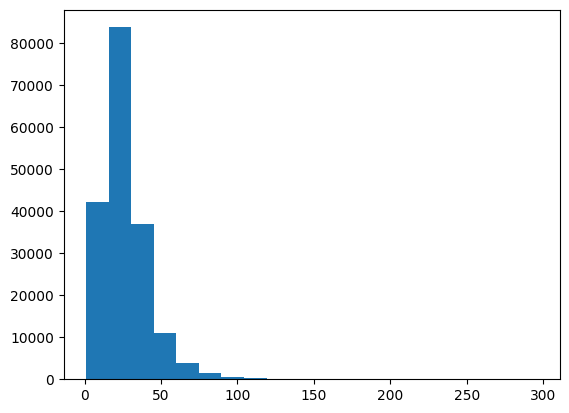

In [27]:
# What's the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=20)

In [28]:
# How long of a sentence covers 95% of the lengths?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [29]:
# Maximum sequence length in the training set
max(sent_lens)

296

# Create a text vectorizer
we can use the `TextVectorization` layer from TensorFlow to convert our abstract text into numbers.

In [30]:
# How many words are in our vocabulary? (taken from 3.2 in https://arxiv.org/pdf/1710.06071.pdf)
max_tokens = 68000

In [31]:
# Create text vectorizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens, # number of words in the vocabulary
                                    output_sequence_length=output_seq_len)  # desired output length of vectorized sequences

In [32]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [33]:
# Test out text vectorizer on random sentences
import random
target_senetence = random.choice(train_sentences)
print(f"Text:\n{target_senetence}")
print(f"\nLength of text: {len(target_senetence.split())}")
print(f"\nVectorized text:\n{text_vectorizer([target_senetence])}")

Text:
at initial testing , feedback trainees demonstrated significantly improved depth compliance , recoil compliance , and accuracy of hand placement .

Length of text: 21

Vectorized text:
[[   15   473   574   877  3165   371    39   170  1920  1022 15521  1022
      3  1257     4   896  1164     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [34]:
# How many words in our training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(rct_20k_text_vocab)}")
print(f"Most common words in the vocabulary: {rct_20k_text_vocab[:5]}")
print(f"least common words in the vocabulary: {rct_20k_text_vocab[-5:]}")

Number of words in vocabulary: 64841
Most common words in the vocabulary: ['', '[UNK]', 'the', 'and', 'of']
least common words in the vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [35]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

### Create custom text embedding

`token_vectorization` layer maps the words in text directly to numbers. However, this doesn't necessarily capture the relationships between those numbers.

To create a richer numerical representation of our text, we can use an **embedding**.

As our model learns (by going through many different examples of abstract sentences and their labels), it'll update its embedding to better represent the relationships between tokens in our corpus.

We can create a trainable embedding layer using TensorFlow's [`Embedding`](https://www.tensorflow.org/tutorials/text/word_embeddings) layer.

Once again, the main parameters we're concerned with here are the inputs and outputs of our `Embedding` layer.

The `input_dim` parameter defines the size of our vocabulary. And the `output_dim` parameter defines the dimension of the embedding output.

Once created, our embedding layer will take the integer outputs of our `text_vectorization` layer as inputs and convert them to feature vectors of size `output_dim`.

In [36]:
# Create a token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab), # length of vocabulary
                                output_dim=128, # Note: different embedding sizes result in drastically different numbers of parameters to train
                                mask_zero=True, # use masking to handle variable sequence lengths
                                name="token_embedding")

# Show an example embedding
print(f"Sentence before vectorization:\n{target_senetence}\n")
vectorized_sentence = text_vectorizer([target_senetence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
at initial testing , feedback trainees demonstrated significantly improved depth compliance , recoil compliance , and accuracy of hand placement .

Sentence after vectorization (before embedding):
[[   15   473   574   877  3165   371    39   170  1920  1022 15521  1022
      3  1257     4   896  1164     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
[[[-0.01364141  0.00755841  0.02732472 ... -0.02679016  0.01591751
   -0.00742786]
  [ 0.02221676  0.00712901  0.03230563 ... -0.03731326 -0.01781949
   -0.03550782]
  [-0.00847634 -0.03133593 -0.01285036 ... -0.04806806  0.00865217
   -0.03518514]
  ...
  [-0.00810649  0.02235251 -0.0121176  ...  0.04065171 -0.01519101
   -0.03162189]
  [-0.00810649  0.02235251 -0.0121176  ...  0.04065171 -0.0151910

## Creating datasets (making sure our data loads as fast as possible)
## Create datasets (as fast as possible)

`tf.data` API provides methods which enable faster data loading.

> 📖 **Resource:** For best practices on data loading in TensorFlow, check out the following:
* [tf.data: Build TensorFlow input pipelines](https://www.tensorflow.org/guide/data)
* [Better performance with the tf.data API](https://www.tensorflow.org/guide/data_performance)

The main steps we'll want to use with our data is to turn it into a `PrefetchDataset` of batches.

Doing so we'll ensure TensorFlow loads our data onto the GPU as fast as possible, in turn leading to faster training time.

To create a batched `PrefetchDataset` we can use the methods [`batch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch) and [`prefetch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch), the parameter [`tf.data.AUTOTUNE`](https://www.tensorflow.org/api_docs/python/tf/data#AUTOTUNE) will also allow TensorFlow to determine the optimal amount of compute to use to prepare datasets.

In [37]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [38]:
# Take the TensorFlow Datasets and turn them into prefetched datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Conv1D with token embeddings


In [39]:
# Create 1D Convolutional Neural Network
inputs = layers.Input(shape=(1,), dtype=tf.string) # inputs are 1-dimensional strings
text_vectors = text_vectorizer(inputs) # turn the input text into numbers
token_embeddings = token_embed(text_vectors) # create embedding
x = layers.Conv1D(filters=64, kernel_size=5, padding="same", activation="relu")(token_embeddings) # convolutional layer
x = layers.GlobalAveragePooling1D()(x) # reduce the tensor from (batch_size, 10, 64) to (batch_size, 64)
outputs = layers.Dense(num_classes, activation="softmax")(x) # create the output layer, want one output per class
model_1 = tf.keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [40]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 token_embedding (Embedding  (None, 55, 128)           8299648   
 )                                                               
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                             

In [41]:
# Fit the model
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)), # only fit on 10% of batches for faster training time
                              epochs=3, # only train for 3 epochs for rapid prototyping
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/3


562/562 [==============================] - 86s 151ms/step - loss: 0.9118 - accuracy: 0.6421 - val_loss: 0.6802 - val_accuracy: 0.7420
Epoch 2/3
562/562 [==============================] - 80s 142ms/step - loss: 0.6532 - accuracy: 0.7591 - val_loss: 0.6315 - val_accuracy: 0.7736
Epoch 3/3
562/562 [==============================] - 78s 139ms/step - loss: 0.6139 - accuracy: 0.7756 - val_loss: 0.5934 - val_accuracy: 0.7842


In [42]:
# Evaluate on the whole validation dataset
model_1.evaluate(valid_dataset)

 12/945 [..............................] - ETA: 4s - loss: 0.5884 - accuracy: 0.7422 

945/945 [==============================] - 4s 4ms/step - loss: 0.5943 - accuracy: 0.7880


[0.5943213701248169, 0.7880312204360962]

In [43]:
# Make predictions (our model predicts prediction probabilities for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

945/945 [==============================] - 4s 4ms/step


(array([[4.6730202e-01, 1.5501443e-01, 6.4621247e-02, 2.8788304e-01,
         2.5179194e-02],
        [4.0273890e-01, 3.0615515e-01, 1.3076607e-02, 2.6761055e-01,
         1.0418802e-02],
        [1.4298178e-01, 5.7771914e-03, 1.6785575e-03, 8.4954375e-01,
         1.8757815e-05],
        ...,
        [1.1440911e-05, 6.3459383e-04, 6.7401933e-04, 4.5744291e-06,
         9.9867529e-01],
        [4.8235688e-02, 5.0702292e-01, 7.0583232e-02, 5.7800468e-02,
         3.1635773e-01],
        [1.6040933e-01, 6.9822842e-01, 4.5490518e-02, 5.6090973e-02,
         3.9780706e-02]], dtype=float32),
 (30212, 5))

In [44]:
# Turn prediction probabilities into prediction classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1], dtype=int64)>

In [45]:
# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.80312458625711,
 'precision': 0.7852814555015676,
 'recall': 0.7880312458625711,
 'f1': 0.7857704328239}

## Model 2: Feature extraction with pretrained token embeddings

Since we're moving towards replicating the model architecture in [*Neural Networks for Joint Sentence Classification
in Medical Paper Abstracts*](https://arxiv.org/pdf/1612.05251.pdf), it mentions they used a [pretrained GloVe embedding](https://nlp.stanford.edu/projects/glove/) as a way to initialise their token embeddings.

To emulate this, let's see what results we can get with the [pretrained Universal Sentence Encoder embeddings from TensorFlow Hub](https://tfhub.dev/google/universal-sentence-encoder/4).

> 🔑 **Note:** We could use GloVe embeddings as per the paper but since we're working with TensorFlow, we'll use what's available from TensorFlow Hub (GloVe embeddings aren't). We'll save [using pretrained GloVe embeddings](https://keras.io/examples/nlp/pretrained_word_embeddings/) as an extension.

The model structure will look like:

```
Inputs (string) -> Pretrained embeddings from TensorFlow Hub (Universal Sentence Encoder) -> Layers -> Output (prediction probabilities)
```

You'll notice the lack of tokenization layer we've used in a previous model. This is because the Universal Sentence Encoder (USE) takes care of tokenization for us.

This type of model is called transfer learning, or more specifically, **feature extraction transfer learning**. In other words, taking the patterns a model has learned elsewhere and applying it to our own problem.

To download the pretrained USE into a layer we can use in our model, we can use the [`hub.KerasLayer`](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer) class.

We'll keep the pretrained embeddings frozen (by setting `trainable=False`) and add a trainable couple of layers on the top to tailor the model outputs to our own data.

> 🔑 **Note:** Due to having to download a relatively large model (~916MB), the cell below may take a little while to run.

In [47]:
# Download pretrained TensorFlow Hub Universal Sentence Encoder
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [48]:
# Test out the pretrained embedding on a random sentence
random_train_sentence = random.choice(train_sentences)
print(f"Random sentence:\n{random_train_sentence}\n")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]} (truncated output)...\n")
print(f"Length of sentence embedding: {len(use_embedded_sentence[0])}")


Random sentence:
fixed bearing and mb groups differed from controls in six and five parameters at nine months post-surgery , respectively .

Sentence after embedding:
[-0.0199479  -0.02201457 -0.00733428 -0.03274244 -0.06165738 -0.05384772
  0.0480983  -0.04684338 -0.09302537  0.0535419   0.06433465 -0.05864108
 -0.05494441 -0.01474441  0.01805101  0.01304372 -0.04998137  0.05439383
  0.00872927  0.05787643 -0.00536448  0.05738879 -0.04195217 -0.04251784
 -0.035981   -0.01227441 -0.02263026  0.07205369 -0.06493563 -0.03924659] (truncated output)...

Length of sentence embedding: 512


### Building and fitting an NLP feature extraction model from TensorFlow Hub

In [49]:
# Define feature extraction model using TF Hub layer
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize text and create embedding of each sequence (512 long vector)
x = layers.Dense(128, activation="relu")(pretrained_embedding) # add a fully connected layer on top of the embedding
outputs = layers.Dense(num_classes, activation="softmax")(x) # create the output layer
model_2 = tf.keras.Model(inputs, outputs, name="model_2_USE")

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [50]:
model_2.summary()

Model: "model_2_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder  (None, 512)               256797824 
  (KerasLayer)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256864133 (979.86 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [51]:
# Fit the model
history_model_2 = model_2.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/3


562/562 [==============================] - 11s 13ms/step - loss: 0.9165 - accuracy: 0.6474 - val_loss: 0.7983 - val_accuracy: 0.6885
Epoch 2/3
562/562 [==============================] - 6s 10ms/step - loss: 0.7705 - accuracy: 0.7003 - val_loss: 0.7574 - val_accuracy: 0.7011
Epoch 3/3
562/562 [==============================] - 6s 11ms/step - loss: 0.7546 - accuracy: 0.7099 - val_loss: 0.7410 - val_accuracy: 0.7144


In [52]:
# Evaluate on the whole validation dataset
model_2.evaluate(valid_dataset)

  8/945 [..............................] - ETA: 8s - loss: 0.7929 - accuracy: 0.6797 

945/945 [==============================] - 8s 8ms/step - loss: 0.7437 - accuracy: 0.7123


[0.7436532974243164, 0.7122666239738464]

In [53]:
# Make predictions with USE TF Hub model
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs[:10]

945/945 [==============================] - 9s 9ms/step


array([[4.20986623e-01, 3.89240116e-01, 2.50909664e-03, 1.78332031e-01,
        8.93217232e-03],
       [3.22679281e-01, 5.34873486e-01, 3.25895357e-03, 1.35829568e-01,
        3.35868308e-03],
       [2.34921768e-01, 1.47958234e-01, 2.38215141e-02, 5.51516891e-01,
        4.17816192e-02],
       [1.23258876e-02, 4.69467901e-02, 8.09117734e-01, 8.80011916e-03,
        1.22809425e-01],
       [2.59200186e-02, 2.32208312e-01, 2.47487709e-01, 1.06169470e-02,
        4.83767003e-01],
       [9.89526394e-04, 2.71304441e-03, 6.90166354e-01, 1.08284301e-04,
        3.06022823e-01],
       [2.10993690e-03, 4.19101957e-03, 6.55928195e-01, 1.24770228e-03,
        3.36523145e-01],
       [3.86644993e-03, 2.52174418e-02, 4.52610224e-01, 9.40412399e-04,
        5.17365515e-01],
       [4.53163637e-04, 7.00498745e-03, 2.49018278e-02, 8.97842285e-04,
        9.66742218e-01],
       [1.27416775e-01, 6.94686651e-01, 2.58647390e-02, 7.90957138e-02,
        7.29361326e-02]], dtype=float32)

In [54]:
# Convert prediction probabilities to class labels
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2], dtype=int64)>

In [55]:
# Calculate model_2 results
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 71.2266649013637,
 'precision': 0.7130267574371254,
 'recall': 0.712266649013637,
 'f1': 0.709133953681072}

# Model 3 : Conv1D with character embeddings


### Creating a character-level tokenizer

The [*Neural Networks for Joint Sentence Classification
in Medical Paper Abstracts*](https://arxiv.org/pdf/1612.05251.pdf) paper mentions their model uses a hybrid of token and character embeddings.

We've built models with a custom token embedding and a pretrained token embedding, how about we build one using a character embedding?

The difference between a character and token embedding is that the **character embedding** is created using sequences split into characters (e.g. `hello` -> [`h`, `e`, `l`, `l`, `o`]) where as a **token embedding** is created on sequences split into tokens.

We can create a character-level embedding by first vectorizing our sequences (after they've been split into characters) using the [`TextVectorization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/TextVectorization) class and then passing those vectorized sequences through an [`Embedding`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) layer.

Before we can vectorize our sequences on a character-level we'll need to split them into characters. Let's write a function to do so.

In [56]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [57]:
# Make functions to split sentences into characters
def split_chars(text):
    return " ".join(list(text))

# Text splitting non-character-level sequence into characters
split_chars(random_train_sentence)

'f i x e d   b e a r i n g   a n d   m b   g r o u p s   d i f f e r e d   f r o m   c o n t r o l s   i n   s i x   a n d   f i v e   p a r a m e t e r s   a t   n i n e   m o n t h s   p o s t - s u r g e r y   ,   r e s p e c t i v e l y   .'

In [58]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [59]:
# whatis the avg character length?
char_lens = [len(sentence) for sentence in train_sentences]
avg_char_len = np.mean(char_lens)
avg_char_len

149.3662574983337

(array([2.2108e+04, 7.0583e+04, 5.3952e+04, 2.2391e+04, 7.4540e+03,
        2.2350e+03, 8.0200e+02, 2.8700e+02, 1.1800e+02, 4.9000e+01,
        2.9000e+01, 1.3000e+01, 8.0000e+00, 5.0000e+00, 1.0000e+00,
        2.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([1.00000e+00, 7.02500e+01, 1.39500e+02, 2.08750e+02, 2.78000e+02,
        3.47250e+02, 4.16500e+02, 4.85750e+02, 5.55000e+02, 6.24250e+02,
        6.93500e+02, 7.62750e+02, 8.32000e+02, 9.01250e+02, 9.70500e+02,
        1.03975e+03, 1.10900e+03, 1.17825e+03, 1.24750e+03, 1.31675e+03,
        1.38600e+03]),
 <BarContainer object of 20 artists>)

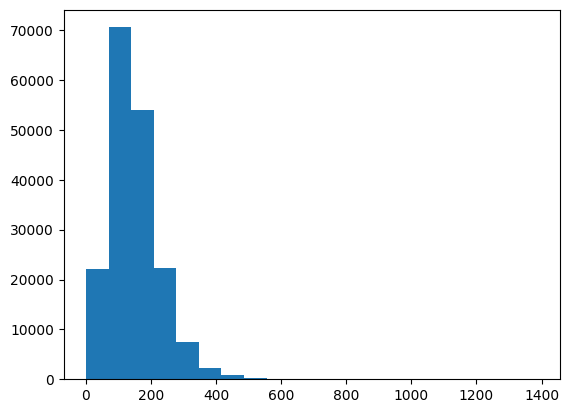

In [60]:
# check the distribution of our character lengths
plt.hist(char_lens, bins=20)

In [61]:
# Find what character length covers 95% of sequences
output_char_len = int(np.percentile(char_lens, 95))
output_char_len

290

In [62]:
# Get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [63]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and OOV token (OOV = out of vocabulary)
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS, # number of different characters
                                    output_sequence_length=output_char_len, # length of character-level sequences
                                    name="char_vectorizer")

In [64]:
# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [65]:
# Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [66]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of random charified text: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nCharified text after vectorization:\n{vectorized_chars}")
print(f"\nCharified text after vectorization shape: {vectorized_chars.shape}")


Charified text:
i n   @   p a t i e n t s   f r o m   t h e   d r u g   g r o u p   ,   t h e   s t o n e   w a s   c o m p l e t e l y   d i s s o l v e d   .

Length of random charified text: 59

Charified text after vectorization:
[[ 4  6 14  5  3  4  2  6  3  9 17  8  7 15  3 13  2 10  8 16 18 18  8  7
  16 14  3 13  2  9  3  7  6  2 20  5  9 11  7 15 14 12  2  3  2 12 19 10
   4  9  9  7 12 21  2 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0 

## Creating a character-level embedding

In [67]:
# Create char-level embedding
char_embed = layers.Embedding(input_dim=len(char_vocab), # number of different characters
                               output_dim=25, # embedding dimension of each character (same as Figure 1 in https://arxiv.org/pdf/1612.05251.pdf)
                               mask_zero=True, # use masking to handle variable sequence lengths
                               name="char_embed")

# Test out character embedding
print(f"Charified text before vectorization:\n{random_train_chars}\n")
char_embed_example = char_embed(vectorized_chars)   
print(f"Embedded charified text:\n{char_embed_example}\n")
print(f"Embedded charified text shape: {char_embed_example.shape}")

Charified text before vectorization:
i n   @   p a t i e n t s   f r o m   t h e   d r u g   g r o u p   ,   t h e   s t o n e   w a s   c o m p l e t e l y   d i s s o l v e d   .

Embedded charified text:
[[[-0.01586564  0.04892204  0.02248028 ... -0.01772263 -0.03356741
    0.03183554]
  [ 0.0276061   0.04164303 -0.03674626 ...  0.01260949 -0.00211217
    0.00664052]
  [ 0.01387146  0.02703694 -0.03099501 ... -0.02503556  0.03147751
   -0.02443506]
  ...
  [-0.00299584 -0.04255646  0.01435995 ...  0.02128782  0.01808676
   -0.04492798]
  [-0.00299584 -0.04255646  0.01435995 ...  0.02128782  0.01808676
   -0.04492798]
  [-0.00299584 -0.04255646  0.01435995 ...  0.02128782  0.01808676
   -0.04492798]]]

Embedded charified text shape: (1, 290, 25)


## Model 3: Conv1D with character embeddings


In [68]:
# Build a Conv1D model to process character embeddings
inputs = layers.Input(shape=(1,), dtype=tf.string) # inputs are 1-dimensional strings
char_vectors = char_vectorizer(inputs) # turn the input text into numbers
char_embeddings = char_embed(char_vectors) # create character embeddings
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings) # convolutional layer
x = layers.GlobalMaxPooling1D()(x) # reduce tensor from (batch_size, 10, 64) to (batch_size, 64)
outputs = layers.Dense(num_classes, activation="softmax")(x) # create the output layer
model_3 = tf.keras.Model(inputs, outputs, name="model_3_conv1d_char_embedding")

# Compile Conv1D model
model_3.compile(loss="categorical_crossentropy",
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=["accuracy"])

In [69]:
model_3.summary()

Model: "model_3_conv1d_char_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVecto  (None, 290)               0         
 rization)                                                       
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_3 (Dense)             (None, 5

In [70]:
# Create char-level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
valid_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset


<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [71]:
# Fit the model on chars
history_model_3 = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_dataset)),
                              epochs=3,
                              validation_data=valid_char_dataset,
                              validation_steps=int(0.1 * len(valid_char_dataset)))

Epoch 1/3


562/562 [==============================] - 10s 15ms/step - loss: 1.2757 - accuracy: 0.4774 - val_loss: 1.0559 - val_accuracy: 0.5715
Epoch 2/3
562/562 [==============================] - 8s 15ms/step - loss: 1.0146 - accuracy: 0.5950 - val_loss: 0.9564 - val_accuracy: 0.6203
Epoch 3/3
562/562 [==============================] - 8s 14ms/step - loss: 0.9350 - accuracy: 0.6319 - val_loss: 0.8830 - val_accuracy: 0.6626


In [72]:
# Make predictions with character model
model_3_pred_probs = model_3.predict(valid_char_dataset)
model_3_pred_probs

945/945 [==============================] - 4s 4ms/step


array([[0.21858627, 0.45310116, 0.08968391, 0.17736   , 0.06126869],
       [0.24276035, 0.4329829 , 0.01015889, 0.2942639 , 0.01983398],
       [0.21491814, 0.2636841 , 0.13048919, 0.3562574 , 0.03465124],
       ...,
       [0.02788897, 0.02595965, 0.0901484 , 0.01619945, 0.8398036 ],
       [0.03930002, 0.13563572, 0.50704294, 0.06541927, 0.25260204],
       [0.3821694 , 0.5011694 , 0.05696102, 0.05403372, 0.00566643]],
      dtype=float32)

In [73]:
# Convert prediction probabilities to class labels
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 2, 1], dtype=int64)>

In [74]:
# Calculate model_3 results
model_3_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 64.92453329802727,
 'precision': 0.6499056511401409,
 'recall': 0.6492453329802728,
 'f1': 0.6402223437510812}

## Model 4: Combining pretrained token embeddings + character embeddings (hybrid embedding layer)

1. Create a token-level model (similar to `model_1`) with pretrained embeddings.
2. Create a character-level model (similar to `model_3`) with a character embedding (with a slight modification).
3. Combine (using [`layers.Concatenate`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Concatenate)) the outputs of 1 and 2.
4. Build a series of output layers on top of 3 similar to Figure 1 and section 4.2 of [*Neural Networks for Joint Sentence Classification in Medical Paper Abstracts*](https://arxiv.org/pdf/1612.05251.pdf).
5. Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output.


In [75]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                                outputs=token_outputs)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings) # bi-LSTM for sequence modelling shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = tf.keras.layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                            char_model.output])

# 4. Create output layers
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")


In [76]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_input[0][0]']          
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978 

In [77]:
# Compile token char model
model_4.compile(loss="categorical_crossentropy",
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=["accuracy"])

In [78]:
# Combine token and char datasets into a dataset
train_token_char_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_token_char_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_token_char_dataset = tf.data.Dataset.zip((train_token_char_data, train_token_char_labels)) # combine data and labels

# Prefetch and batch the train data
train_char_token_dataset = train_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [79]:
# Repeat the above process for validation data
val_token_char_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_token_char_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_token_char_dataset = tf.data.Dataset.zip((val_token_char_data, val_token_char_labels))
val_char_token_dataset = val_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [80]:
# Checkout the training char and token dataset
train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [81]:
# Fit the model on tokens and chars
history_model_4 = model_4.fit(train_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/3


562/562 [==============================] - 75s 118ms/step - loss: 0.9806 - accuracy: 0.6060 - val_loss: 0.7742 - val_accuracy: 0.7045
Epoch 2/3
562/562 [==============================] - 63s 113ms/step - loss: 0.8015 - accuracy: 0.6929 - val_loss: 0.7212 - val_accuracy: 0.7284
Epoch 3/3
562/562 [==============================] - 64s 114ms/step - loss: 0.7779 - accuracy: 0.7042 - val_loss: 0.6907 - val_accuracy: 0.7364


In [82]:
# Evaluate on the whole validation dataset
model_4.evaluate(val_char_token_dataset)


  1/945 [..............................] - ETA: 40s - loss: 1.0284 - accuracy: 0.5000

945/945 [==============================] - 29s 30ms/step - loss: 0.6957 - accuracy: 0.7356


[0.695660412311554, 0.735568642616272]

In [83]:
# Make Predictions with token char model
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

945/945 [==============================] - 31s 30ms/step


array([[4.0557569e-01, 3.7534595e-01, 4.0273005e-03, 2.0882274e-01,
        6.2283352e-03],
       [3.1241000e-01, 5.0562191e-01, 3.2515835e-03, 1.7646703e-01,
        2.2495356e-03],
       [2.9084054e-01, 1.5615472e-01, 6.9736026e-02, 4.3873844e-01,
        4.4530321e-02],
       ...,
       [7.5436308e-04, 7.0573725e-03, 6.2854543e-02, 3.5461914e-04,
        9.2897910e-01],
       [7.0565194e-03, 4.2094570e-02, 2.6484331e-01, 3.5361100e-03,
        6.8246949e-01],
       [3.5104224e-01, 3.9191946e-01, 1.8623427e-01, 3.0830968e-02,
        3.9973076e-02]], dtype=float32)

In [84]:
# Convert prediction probabilities to class labels
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1], dtype=int64)>

In [85]:
# Calculate model_4 results
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 73.55686482192506,
 'precision': 0.7356770999174428,
 'recall': 0.7355686482192506,
 'f1': 0.7327299561400599}

## Model 5 : Transfer learning with pretrained token embeddings + character embeddings + positional embeddings


It seems like combining token embeddings and character embeddings gave our model a little performance boost.

But there's one more piece of the puzzle we can add in.

What if we engineered our own features into the model?

Meaning, what if we took our own knowledge about the data and encoded it in a numerical way to give our model more information about our samples?

The process of applying your own knowledge to build features as input to a model is called **feature engineering**.

Can you think of something important about the sequences we're trying to classify?

If you were to look at an abstract, would you expect the sentences to appear in order? Or does it make sense if they were to appear sequentially? For example, sequences labelled `CONCLUSIONS` at the beggining and sequences labelled `OBJECTIVE` at the end?

Abstracts typically come in a sequential order, such as:
* `OBJECTIVE` ...
* `METHODS` ...
* `METHODS` ...
* `METHODS` ...
* `RESULTS` ...
* `CONCLUSIONS` ...

Or

* `BACKGROUND` ...
* `OBJECTIVE` ...
* `METHODS` ...
* `METHODS` ...
* `RESULTS` ...
* `RESULTS` ...
* `CONCLUSIONS` ...
* `CONCLUSIONS` ...

Of course, we can't engineer the sequence labels themselves into the training data (we don't have these at test time), but we can encode the order of a set of sequences in an abstract.

For example,
* `Sentence 1 of 10` ...
* `Sentence 2 of 10` ...
* `Sentence 3 of 10` ...
* `Sentence 4 of 10` ...
* ...


You might've noticed this when we created our `preprocess_text_with_line_numbers()` function. When we read in a text file of abstracts, we counted the number of lines in an abstract as well as the number of each line itself.

Doing this led to the `"line_number"` and `"total_lines"` columns of our DataFrames.

### Create positional embeddings

In [86]:
# How many different line numbers are there?
train_df["line_number"].value_counts()

line_number
0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

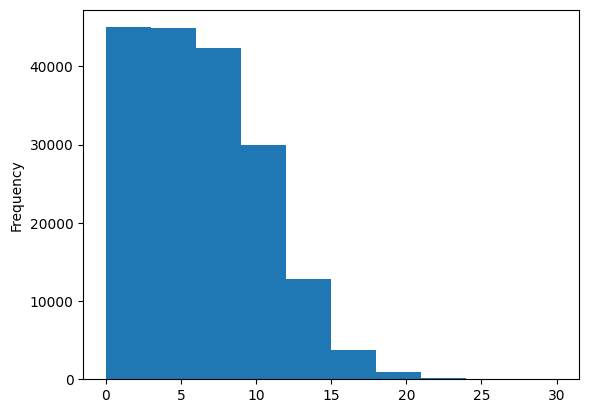

In [87]:
# Distribution of "line number" column
train_df["line_number"].plot.hist()

In [88]:
# Use tensorflow to create one-hot-encoded tensors of our "line_number" column
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

train_line_numbers_one_hot[:10], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>,
 TensorShape([180040, 15]))

In [89]:
# How many different numbers of lines are there?
train_df["total_lines"].value_counts()

total_lines
11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

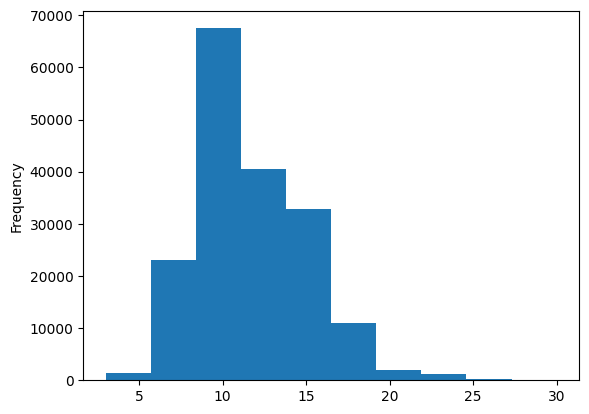

In [90]:
# Check the distribution of total lines
train_df["total_lines"].plot.hist()

In [91]:
# Check the ccoverage of a "total lines" value of 20
np.percentile(train_df["total_lines"], 98)

20.0

In [92]:
# Use tensorflow to create one-hot-encoded tensors of our "total_lines" column
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

train_total_lines_one_hot[:10], train_total_lines_one_hot.shape

(<tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0

### Building a tribid embedding model

1. create a token-level model (similar to `model_4`) with pretrained embeddings.
2. Create a character-level model (similar to `model_4`) with a character embedding.
3. Create a model for the "line number" feature
4. Create a model for the "total lines" feature
5. Combine the outputs of 1, 2 using [`layers.Concatenate`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Concatenate).
6. Combine the outputs of 3, 4, 5 using [`layers.Concatenate`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Concatenate).
7. Create an output layer to accept the embedding and output label probabilities.
8. Combine the inputs of 1, 2, 3, 4 and outputs into a `tf.keras.Model`.

In [93]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Line numbers inputs
line_number_inputs = layers.Input(shape=(15,), dtype=tf.int32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. Total lines inputs
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.int32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output, 
                                                                              char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with combined token and char embeddings into a tribrid embedding
z = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output,
                                                                total_line_model.output,
                                                                z])

# 7. Create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(z)

# 8. Put together model
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input, 
                                 char_model.input],
                         outputs=output_layer,
                         name="tribrid_embedding_model")

In [94]:
# Summary of model
model_5.summary()

Model: "tribrid_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_inputs[0][0]']         
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['token_

In [95]:
# Check which layers of our model are trainable or not
for layer in model_5.layers:
  print(layer, layer.trainable)

<keras.src.engine.input_layer.InputLayer object at 0x000001ED64D14A60> True
<keras.src.engine.input_layer.InputLayer object at 0x000001ED66E33280> True
<keras.src.layers.preprocessing.text_vectorization.TextVectorization object at 0x000001ED41EAA9E0> True
<tensorflow_hub.keras_layer.KerasLayer object at 0x000001ECCC74ABC0> False
<keras.src.layers.core.embedding.Embedding object at 0x000001ED41EAB070> True
<keras.src.layers.core.dense.Dense object at 0x000001ED64D70E50> True
<keras.src.layers.rnn.bidirectional.Bidirectional object at 0x000001ED66E94AF0> True
<keras.src.layers.merging.concatenate.Concatenate object at 0x000001ED671B4760> True
<keras.src.engine.input_layer.InputLayer object at 0x000001ED425247F0> True
<keras.src.engine.input_layer.InputLayer object at 0x000001ED67110280> True
<keras.src.layers.core.dense.Dense object at 0x000001ED6732FD30> True
<keras.src.layers.core.dense.Dense object at 0x000001ED423E5A50> True
<keras.src.layers.core.dense.Dense object at 0x000001ED6709

`label_smoothing`. Label smoothing helps to regularize our model (prevent overfitting) by making sure it doesn't get too focused on applying one particular label to a sample.

For example, instead of having an output prediction of: 
* `[0.0, 0.0, 1.0, 0.0, 0.0]` for a sample (the model is very confident the right label is index 2).

It's predictions will get smoothed to be something like:
* `[0.01, 0.01, 0.096, 0.01, 0.01]` giving a small activation to each of the other labels, in turn, hopefully improving generalization.

> 📖 **Resource:** For more on label smoothing, see the great blog post by PyImageSearch, [*Label smoothing with Keras, TensorFlow, and Deep Learning*](https://www.pyimagesearch.com/2019/12/30/label-smoothing-with-keras-tensorflow-and-deep-learning/).

In [96]:
# Compile the model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), 
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=["accuracy"])

### Create tribrid embedding datasets and fit tribrid model

fit on 20k examples for 3 epochs.

This time our model requires four feature inputs:
1. Train line numbers one-hot tensor (`train_line_numbers_one_hot`)
2. Train total lines one-hot tensor (`train_total_lines_one_hot`)
3. Token-level sequences tensor (`train_sentences`)
4. Char-level sequences tensor (`train_chars`)

We can pass these as tuples to our `tf.data.Dataset.from_tensor_slices()` method to create appropriately shaped and batched `PrefetchedDataset`'s.

In [97]:
# Create training and validation datasets (with all kind of input data)
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, 
                                                                train_total_lines_one_hot, 
                                                                train_sentences, 
                                                                train_chars))
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

# Validation dataset
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot, 
                                                              val_total_lines_one_hot, 
                                                              val_sentences, 
                                                              val_chars))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels)).batch(32).prefetch(tf.data.AUTOTUNE)


In [98]:
# Check input shapes
train_char_token_pos_data, val_char_token_pos_data

(<_TensorSliceDataset element_spec=(TensorSpec(shape=(15,), dtype=tf.float32, name=None), TensorSpec(shape=(20,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>,
 <_TensorSliceDataset element_spec=(TensorSpec(shape=(15,), dtype=tf.float32, name=None), TensorSpec(shape=(20,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>)

### Fitting, evaluating and making predictions with the tribid model

In [99]:
# Fit the model
history_model_5 = model_5.fit(train_char_token_pos_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_pos_dataset)),
                              epochs=3,
                              validation_data=val_char_token_pos_dataset,
                              validation_steps=int(0.1 * len(val_char_token_pos_dataset)))

Epoch 1/3


562/562 [==============================] - 78s 123ms/step - loss: 1.1004 - accuracy: 0.7213 - val_loss: 0.9845 - val_accuracy: 0.8022
Epoch 2/3
562/562 [==============================] - 65s 116ms/step - loss: 0.9667 - accuracy: 0.8158 - val_loss: 0.9516 - val_accuracy: 0.8268
Epoch 3/3
562/562 [==============================] - 65s 116ms/step - loss: 0.9499 - accuracy: 0.8249 - val_loss: 0.9410 - val_accuracy: 0.8305


In [100]:
# Make predictions with the char token pos model
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset)
model_5_pred_probs

945/945 [==============================] - 32s 31ms/step


array([[0.48351204, 0.11156559, 0.01035904, 0.37876713, 0.01579627],
       [0.55077976, 0.1012202 , 0.05376242, 0.28292525, 0.01131244],
       [0.264539  , 0.11139369, 0.11140203, 0.44756353, 0.06510185],
       ...,
       [0.03242179, 0.11782967, 0.05011838, 0.03447792, 0.7651523 ],
       [0.03101969, 0.28950542, 0.09721871, 0.03009011, 0.55216604],
       [0.2131993 , 0.6358956 , 0.06139148, 0.0397186 , 0.04979504]],
      dtype=float32)

In [101]:
# Convert prediction probabilities to class labels
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1], dtype=int64)>

In [102]:
# Calculate model_5 results
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 83.22851846948232,
 'precision': 0.8313857837467141,
 'recall': 0.8322851846948233,
 'f1': 0.8313814631903601}

## Compare model results

In [103]:
# Combine all of our model results into a DataFrame
all_model_results = pd.DataFrame({"model_0_baseline": baseline_results,
                                    "model_1_custom_token_embedding": model_1_results,
                                    "model_2_pretrained_token_embedding": model_2_results,
                                    "model_3_custom_char_embedding": model_3_results,
                                    "model_4_token_and_char_embedding": model_4_results,
                                    "model_5_tribrid_embedding": model_5_results})

all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,72.183238,0.718647,0.721832,0.698925
model_1_custom_token_embedding,78.803125,0.785281,0.788031,0.785770
model_2_pretrained_token_embedding,71.226665,0.713027,0.712267,0.709134
model_3_custom_char_embedding,64.924533,0.649906,0.649245,0.640222
model_4_token_and_char_embedding,73.556865,0.735677,0.735569,0.732730
model_5_tribrid_embedding,83.228518,0.831386,0.832285,0.831381


In [104]:
# Reduce the accuracy to the same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"] / 100

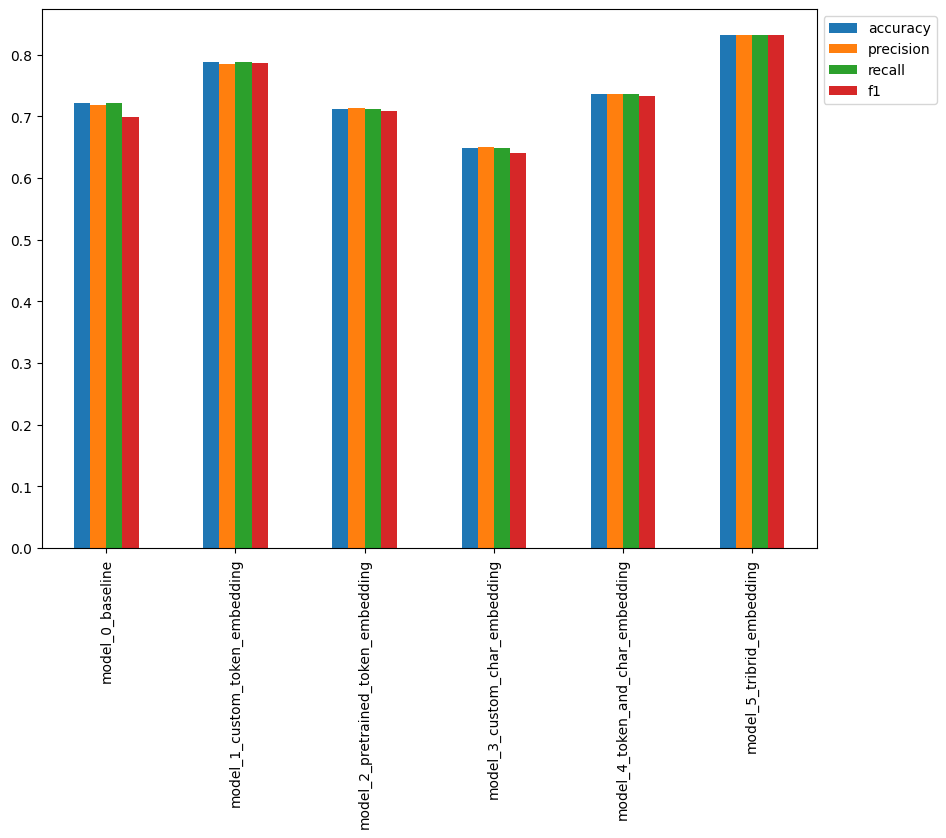

In [105]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

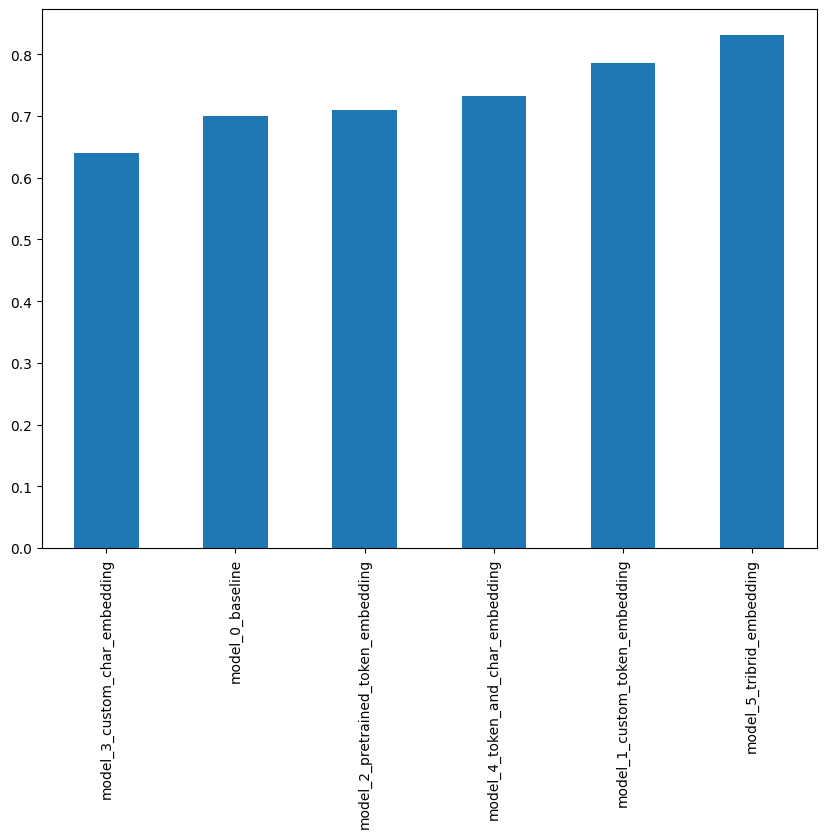

In [106]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=True)["f1"].plot(kind="bar", figsize=(10, 7));

## Save and Load and Test Model

In [107]:
# save the best performing model to SaveModel format
model_5.save("PaperPilot_tribrid_model")

Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x000001ED8297BE20>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x000001ED8297BE20>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x000001ED8297BE20>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('signature_function', 'signature_key'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('signature_function', 'signature_key'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('signature_function', 'signature_key'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
INFO:tensorflow:Assets written to: PaperPilot_tribrid_model\assets


INFO:tensorflow:Assets written to: PaperPilot_tribrid_model\assets


In [108]:
# Load in best model
loaded_model = tf.keras.models.load_model("PaperPilot_tribrid_model")

In [109]:
# Make predictions with the loaded model
loaded_pred_probs = loaded_model.predict(val_char_token_pos_dataset)
loaded_preds = tf.argmax(loaded_pred_probs, axis=1)
loaded_preds[:10]

945/945 [==============================] - 35s 34ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1], dtype=int64)>

In [110]:
# Calculate the results of loaded model
loaded_model_results = calculate_results(y_true=val_labels_encoded,
                                         y_pred=loaded_preds)
loaded_model_results

{'accuracy': 83.22851846948232,
 'precision': 0.8313857837467141,
 'recall': 0.8322851846948233,
 'f1': 0.8313814631903601}

In [111]:
assert loaded_model_results == model_5_results

In [112]:
# Check the loaded model summary
loaded_model.summary()

Model: "tribrid_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_inputs[0][0]']         
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['token_

In [113]:
# Turn the Test dataset into a test dataset
test_char_token_pos_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                               test_total_lines_one_hot,
                                                               test_sentences,
                                                               test_chars))
test_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_char_token_pos_dataset = tf.data.Dataset.zip((test_char_token_pos_data, test_char_token_pos_labels)).batch(32).prefetch(tf.data.AUTOTUNE)


In [115]:
# make predictions on the test dataset
test_pred_probs = loaded_model.predict(test_char_token_pos_dataset)
test_preds = tf.argmax(test_pred_probs, axis=1)
test_preds[:10]

  2/942 [..............................] - ETA: 1:02

942/942 [==============================] - 35s 37ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([3, 0, 2, 2, 4, 4, 4, 1, 4, 0], dtype=int64)>

In [116]:
# Calculate the results of the test dataset
test_results = calculate_results(y_true=test_labels_encoded,
                                 y_pred=test_preds)
test_results

{'accuracy': 82.69454123112659,
 'precision': 0.825753078451239,
 'recall': 0.826945412311266,
 'f1': 0.8259333346706097}